In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
import sklearn as skl
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from scipy import stats

/home/yamroz/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# XGBOOST, feature importances

In [3]:
# GEOGRAFICZNIE UZUPELNIAMY NA PODSTAWIE BLOKÓW
# geograficzne to:staddr, postcode, latitude, longitude, community board
# council district, census tract, NTA
# STORIES - BIERZEMY SREDNIA Z BLOKOW
# ext na dwie kolumny e i g
# EASEMENT - DWIE KOLUMNY E I N
# obliczyc powierzchnie i normalizować

In [3]:
def calc_average_from_block(dataset, block, column):
    new_df = dataset[dataset["BLOCK"] == block]
    return new_df[column].mean()

def calc_postal_code(data, block, column): # postcode, community board, council district, census tract
    new_df = data[data["BLOCK"] == block]
    return max(new_df[column].unique())

def calc_district(data, block, column):
    new_df = data[data["BLOCK"] == block]
    return new_df[column].unique()[0]

In [4]:
def prepare_data(path):
    data = pd.read_csv(path)
    data.drop(labels=["BBLE", "LOT","PERIOD", "VALTYPE",
                  "Borough", "New Georeferenced Column",
                  "OWNER", "AVLAND2", "AVTOT2",
                  "EXLAND2", "EXTOT2","BIN", "EXCD1", "EXCD2",
                  "EXMPTCL", "YEAR", "STADDR"],axis=1, inplace=True)
    data.drop(labels=["BLDGCL", "NTA","TAXCLASS"] ,axis=1, inplace=True)
    
    data["EASEMENT"] = data["EASEMENT"].fillna("0")
    data["EXT"] = data["EXT"].fillna("0")
    data.loc[(data["EASEMENT"] == "F"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "G"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "H"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "I"), "EASEMENT"] = "E"
    data["EXT_E"] = 0
    data["EXT_G"] = 0
    data["EASEMENT_E"] = 0
    data["EASEMENT_N"] = 0
    data.loc[(data["EXT"] == "E"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "G"), "EXT_G"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_G"] = 1
    data.loc[(data["EASEMENT"] == "E"), "EASEMENT_E"] = 1
    data.loc[(data["EASEMENT"] == "N"), "EASEMENT_N"] = 1
    data.drop(["EXT", "EASEMENT"], axis=1, inplace=True)
    data["STORIES"].fillna(method="ffill", inplace=True)
    data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
    data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
    data["Council District"].loc[data["Council District"].isnull()] = calc_postal_code(data, data["BLOCK"], "Council District")
    data["Census Tract"].loc[data["Census Tract"].isnull()] = calc_postal_code(data, data["BLOCK"], "Census Tract")
#     data["NTA"].loc[data["NTA"].isnull()] = calc_district(data, data["BLOCK"], "NTA")
    data["Latitude"].loc[data["Latitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Latitude")
    data["Longitude"].loc[data["Longitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Longitude")
    data["STORIES"].loc[data["STORIES"].isnull()] = calc_average_from_block(data, data["BLOCK"], "STORIES")
    
    
#     le = preprocessing.OneHotEncoder()
#     encoded_fit = le.fit_transform(data.BLDGCL.values.reshape(-1,1))
#     encoded_fit.toarray()
#     dummies = pd.get_dummies(data[["BLDGCL"]])
#     data = pd.concat([data, dummies], axis = 1)
    
#     encoded_fit = le.fit_transform(data.NTA.values.reshape(-1,1))
#     encoded_fit.toarray()
#     dummies = pd.get_dummies(data[["NTA"]])
#     data = pd.concat([data, dummies], axis = 1)
    
#     encoded_fit = le.fit_transform(data.TAXCLASS.values.reshape(-1,1))
#     encoded_fit.toarray()
#     dummies = pd.get_dummies(data[["TAXCLASS"]])
#     data = pd.concat([data, dummies], axis = 1)
    
    data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
    
    
#     le.fit(data['BLDGCL'])
#     data.BLDGCL = le.transform(data.BLDGCL)
#     le.fit(data['NTA'])
#     data.NTA = le.transform(data.NTA)
#     le.fit(data['TAXCLASS'])
#     data.TAXCLASS = le.transform(data.TAXCLASS)
    return data

In [5]:
def divide_data(data):
    X = data.loc[:, data.columns != 'FULLVAL']
    y = data["FULLVAL"]
    return X, y

In [6]:
def train_test(data):
    train, test = skl.model_selection.train_test_split(data, test_size=25)
    X_train, y_train = divide_data(train)
    X_test, y_test = divide_data(test)
    return X_train, y_train, X_test, y_test

In [7]:
def save_model(X_train, y_train):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=6,
                         eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    model.save_model('model.json')
    return model

In [8]:
X_train, y_train, X_test, y_test = train_test(prepare_data("data/train_data.csv"))

<ipython-input-4-b0cd3f36b8bd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
<ipython-input-4-b0cd3f36b8bd>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
<ipython-input-4-b0cd3f36b8bd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [11]:
model = save_model(X_train, y_train)

/home/yamroz/.local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=6,
                         eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
def split_by_category_plus(self, category):
        mini_categories = []
        values = []
        for value in self.dataset[category].unique():
            values.append(value)
            mini_category = self.dataset[self.dataset[category] == value]
            mini_category.drop(category, axis=1, inplace=True)
            mini_categories.append(mini_category)
        return mini_categories, values

In [10]:
# data = pd.read_csv("data/train_data.csv")
data = prepare_data("data/train_data.csv")
columns = data.columns

<ipython-input-4-b0cd3f36b8bd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
<ipython-input-4-b0cd3f36b8bd>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
<ipython-input-4-b0cd3f36b8bd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BORO              11946 non-null  int64  
 1   BLOCK             11946 non-null  int64  
 2   LTFRONT           11946 non-null  int64  
 3   LTDEPTH           11946 non-null  int64  
 4   STORIES           11946 non-null  float64
 5   FULLVAL           11946 non-null  int64  
 6   AVLAND            11946 non-null  int64  
 7   AVTOT             11946 non-null  int64  
 8   EXLAND            11946 non-null  int64  
 9   EXTOT             11946 non-null  int64  
 10  POSTCODE          11946 non-null  float64
 11  BLDFRONT          11946 non-null  int64  
 12  BLDDEPTH          11946 non-null  int64  
 13  Latitude          11946 non-null  float64
 14  Longitude         11946 non-null  float64
 15  Community Board   11946 non-null  float64
 16  Council District  11946 non-null  float6

In [12]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [145]:
for column in ["AVLAND"]: #, "AVLAND", "AVTOT", "EXTOT", "EXT_E", "EASEMENT_E", "EASEMENT_N"]:
    data = remove_outlier(data, column)

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10213 entries, 1 to 11945
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BORO              10213 non-null  int64  
 1   BLOCK             10213 non-null  int64  
 2   LTFRONT           10213 non-null  int64  
 3   LTDEPTH           10213 non-null  int64  
 4   STORIES           10213 non-null  float64
 5   FULLVAL           10213 non-null  int64  
 6   AVLAND            10213 non-null  int64  
 7   AVTOT             10213 non-null  int64  
 8   EXLAND            10213 non-null  int64  
 9   EXTOT             10213 non-null  int64  
 10  POSTCODE          10213 non-null  float64
 11  BLDFRONT          10213 non-null  int64  
 12  BLDDEPTH          10213 non-null  int64  
 13  Latitude          10213 non-null  float64
 14  Longitude         10213 non-null  float64
 15  Community Board   10213 non-null  float64
 16  Council District  10213 non-null  float6

In [13]:
for column in data.columns:
    print(column, "avg = ", data[column].mean(), " stdev: ", data[column].std(), " diff: ", abs(data[column].std() - data[column].mean())/data[column].mean() )

BORO avg =  3.3311568725933367  stdev:  1.5074516573086878  diff:  0.5474690280391621
BLOCK avg =  2824.9172107818517  stdev:  2901.164736311643  diff:  0.02699106552177093
LTFRONT avg =  36.5323120709861  stdev:  70.69541197846272  diff:  0.9351474891896834
LTDEPTH avg =  81.40030135610246  stdev:  95.23157022803258  diff:  0.16991667894965615
STORIES avg =  5.702620123890842  stdev:  9.450016856300055  diff:  0.6571359569804907
FULLVAL avg =  1335495.8509961492  stdev:  9803228.32575247  diff:  6.340515748094778
AVLAND avg =  93460.50359953122  stdev:  1339795.376099679  diff:  13.33541789845865
AVTOT avg =  410788.9809141135  stdev:  4408330.419257103  diff:  9.731374559871126
EXLAND avg =  43001.1014565545  stdev:  1129310.3966444975  diff:  25.26235976270233
EXTOT avg =  168496.60890674702  stdev:  2625948.837432428  diff:  14.584579740033442
POSTCODE avg =  10635.66047212456  stdev:  502.15362934610107  diff:  0.9527858537171042
BLDFRONT avg =  28.595429432446007  stdev:  42.8839

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BORO              0 non-null      int64  
 1   BLOCK             0 non-null      int64  
 2   LTFRONT           0 non-null      int64  
 3   LTDEPTH           0 non-null      int64  
 4   STORIES           0 non-null      float64
 5   FULLVAL           0 non-null      int64  
 6   AVLAND            0 non-null      int64  
 7   AVTOT             0 non-null      int64  
 8   EXLAND            0 non-null      int64  
 9   EXTOT             0 non-null      int64  
 10  POSTCODE          0 non-null      float64
 11  BLDFRONT          0 non-null      int64  
 12  BLDDEPTH          0 non-null      int64  
 13  Latitude          0 non-null      float64
 14  Longitude         0 non-null      float64
 15  Community Board   0 non-null      float64
 16  Council District  0 non-null      float64
 17  Census Tr

In [12]:
# for column.correlation = data["Latitude"].corr(data["Longitude"])

# correlation 

In [14]:
corr = data.corr()

corr.style.background_gradient(cmap='coolwarm')

,BORO,BLOCK,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,POSTCODE,BLDFRONT,BLDDEPTH,Latitude,Longitude,Community Board,Council District,Census Tract,EXT_E,EXT_G,EASEMENT_E,EASEMENT_N
BORO,1.000000,0.307451,-0.000863,0.148444,-0.530832,-0.082381,-0.056311,-0.089940,-0.032533,-0.058360,0.202654,-0.268143,-0.211089,-0.704853,-0.369623,0.966649,0.890676,0.287494,0.003964,0.363667,0.045443,0.014326
BLOCK,0.307451,1.000000,0.049136,0.139826,-0.341079,-0.048095,-0.035938,-0.051178,-0.021338,-0.034677,0.547520,-0.087969,-0.062253,0.211842,0.674705,0.319812,0.011184,0.460183,0.210549,0.394125,-0.028850,-0.004768
LTFRONT,-0.000863,0.049136,1.000000,0.490388,-0.099540,0.300811,0.323494,0.298207,0.249714,0.292704,0.036956,0.317047,0.270835,0.119509,0.063200,0.022298,0.017172,0.091257,0.015336,0.012788,-0.005071,-0.001104
LTDEPTH,0.148444,0.139826,0.490388,1.000000,-0.235883,0.199380,0.215933,0.182599,0.179843,0.198693,0.160528,0.114610,0.219279,0.041994,0.067667,0.161684,0.143929,0.126865,0.056305,0.117914,0.035693,0.002527
STORIES,-0.530832,-0.341079,-0.099540,-0.235883,1.000000,0.080030,0.048833,0.095016,0.012835,0.053282,-0.310661,0.288587,0.192755,0.107799,-0.021537,-0.527349,-0.502500,-0.158047,-0.072941,-0.206995,-0.035025,-0.005070
FULLVAL,-0.082381,-0.048095,0.300811,0.199380,0.080030,1.000000,0.732218,0.995879,0.457002,0.595882,-0.034113,0.216480,0.275971,0.033799,0.007943,-0.080102,-0.070597,-0.032278,0.003364,-0.037958,-0.013902,-0.001756
AVLAND,-0.056311,-0.035938,0.323494,0.215933,0.048833,0.732218,1.000000,0.735127,0.842418,0.660373,-0.033387,0.123452,0.162746,0.012986,-0.004266,-0.051964,-0.048182,-0.013047,-0.004802,-0.031731,-0.006997,-0.000881
AVTOT,-0.089940,-0.051178,0.298207,0.182599,0.095016,0.995879,0.735127,1.000000,0.458778,0.598953,-0.053237,0.223984,0.276691,0.038457,0.003418,-0.086746,-0.079955,-0.032093,-0.000797,-0.044208,-0.009499,-0.001199
EXLAND,-0.032533,-0.021338,0.249714,0.179843,0.012835,0.457002,0.842418,0.458778,1.000000,0.772654,-0.011505,0.052968,0.057561,0.006880,-0.002643,-0.026404,-0.023151,-0.003069,-0.002062,-0.018605,-0.003751,-0.000467
EXTOT,-0.058360,-0.034677,0.292704,0.198693,0.053282,0.595882,0.660373,0.598953,0.772654,1.000000,-0.021660,0.183044,0.200856,0.029525,0.004209,-0.049768,-0.043382,-0.013385,0.004950,-0.031303,-0.006508,-0.000819


In [15]:
def split_by_category_plus(dataset, category):
        mini_categories = []
        for edge, edge_1 in zip([500000 * i for i in range(0,7)], [500000*i for i in range(1,8)]) :
            mini_category = dataset.loc[(dataset[category] > edge) & (dataset[category] < edge_1)]
            mini_category.drop(category, axis=1, inplace=True)
            mini_categories.append(mini_category)
        return mini_categories

In [16]:
minis = split_by_category_plus(data, "FULLVAL")

<ipython-input-15-7100640e7da9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_category.drop(category, axis=1, inplace=True)
<ipython-input-15-7100640e7da9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_category.drop(category, axis=1, inplace=True)
<ipython-input-15-7100640e7da9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_category.drop(category, axis=1, inplace=True)
<ipython-input-15-7100640e7da9>:5: SettingW

In [20]:
# colors = ["yo", "co", "go", "bo", "ro"]
colors = ["#FF0000", "#DD0022", "#BB0044", "#990066","#770088", "#5500AA", "#3300CC", "#1100FF"]
# colors = ["#bfb800", "#DB8D00", "#E55D2C", "#DB2950","#BA0072", "#80198C", "#002E96", "#0000FF"]


# # for minicat, color in zip(minis, colors):
# plt.figure(figsize=(15,15))
# print(data.columns)
# for column_1 in data.columns:
#     for column_2 in data.columns:
#         i = 0
#         if column_1 != "FULLVAL" and column_2 !="FULLVAL":
#             for minicat in minis:
#                 plt.plot(minicat[column_1].values, minicat[column_2].values, 'o', color = colors[i], markersize=3)
#                 i+=1
#                 plt.ylabel(column_2)
#                 plt.xlabel(column_1)
#             plt.show()
#             plt.clf
                
# plt.figure(figsize=(15,15))
# i = 0
# for minicat in minis:
#     plt.plot(minicat["LTDEPTH"].values, minicat["LTFRONT"].values, 'o', color = colors[i], markersize=8)
#     i+=1
# plt.show()


In [24]:
# data = pd.read_csv("data/train_data.csv")
data = prepare_data("data/train_data.csv")
columns = data.columns

<ipython-input-4-b0cd3f36b8bd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
<ipython-input-4-b0cd3f36b8bd>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
<ipython-input-4-b0cd3f36b8bd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9521 entries, 1 to 11945
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BORO              9521 non-null   int64  
 1   BLOCK             9521 non-null   int64  
 2   LTFRONT           9521 non-null   int64  
 3   LTDEPTH           9521 non-null   int64  
 4   STORIES           9521 non-null   float64
 5   FULLVAL           9521 non-null   int64  
 6   AVLAND            9521 non-null   int64  
 7   AVTOT             9521 non-null   int64  
 8   EXLAND            9521 non-null   int64  
 9   EXTOT             9521 non-null   int64  
 10  POSTCODE          9521 non-null   float64
 11  BLDFRONT          9521 non-null   int64  
 12  BLDDEPTH          9521 non-null   int64  
 13  Latitude          9521 non-null   float64
 14  Longitude         9521 non-null   float64
 15  Community Board   9521 non-null   float64
 16  Council District  9521 non-null   float64

In [27]:
for column in ["AVLAND"]: #, "AVLAND", "AVTOT", "EXTOT", "EXT_E", "EASEMENT_E", "EASEMENT_N"]:
    data = remove_outlier(data, column)

[    0     0     0 ... 35100 35126 35174]


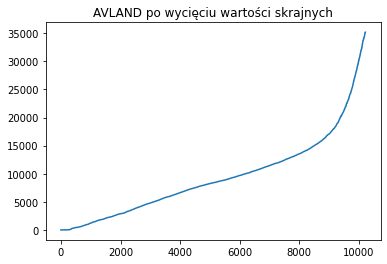

In [28]:
full_values = np.sort(data["AVLAND"].values)
# full_values = data["EASEMENT_E"].values
print(full_values)

# full_values = full_values[225:]
# full_values = full_values[:-500]

xs = [i for i in range (len(full_values))]

# print(full_values)
# print(xs)
plt.plot(xs, full_values)
plt.title("AVLAND po wycięciu wartości skrajnych")
plt.show()

# q1 = np.quantile(full_values,0.25)
# q3 = np.quantile(full_values,0.75)
# iqr = q3 - q1
# print("Q1: " , q1, "Q3: ", q3, "IQR: " , iqr)
# low = q1 - 1.72 * iqr
# hi = q3 + 1.72 * iqr
# print("Lowest val : ", low, "Highest val: ", hi)

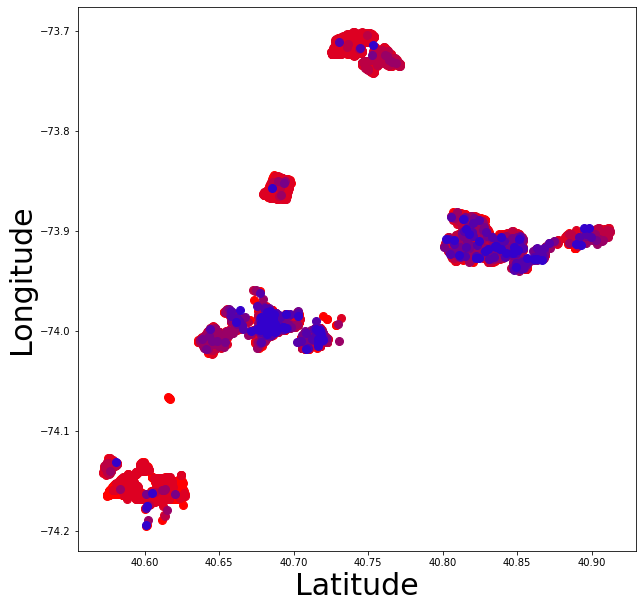

In [40]:
# colors = ["#FE0002", "#D80027", "#63009E", "#412f88", "#0302FC", "#63009E", "#412f88", "#0302FC"]
colors = ["#FF0000", "#DD0022", "#BB0044", "#990066","#770088", "#5500AA", "#3300CC", "#1100FF"]

# colors = ["yo", "co", "go", "bo", "ro"]

# for minicat, color in zip(minis, colors):
plt.figure(figsize=(10,10))
i = 0
for minicat in minis:
    plt.plot(minicat["Latitude"].values, minicat["Longitude"].values, 'o', color = colors[i], markersize=8)
    plt.xlabel("Latitude", fontsize = 30)
    plt.ylabel("Longitude", fontsize = 30)
#     m = plt.pcolormesh(("#FF0000", "#1100FF"))
#     plt.colorbar(m, label='colorbar with length <1', ticks=0.1, loc='r', length=0.7)
#     plt.legend(handles=[mpatches.Patch(color='#A70022', label='1'),
#                     mpatches.Patch(color='#303297', label='5')], 
#                     loc='lower right', edgecolor='black', framealpha=1)
    i+=1
plt.show()

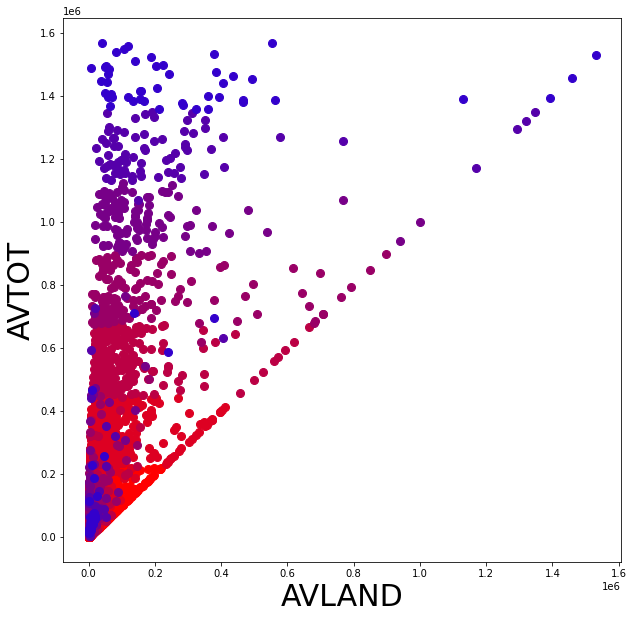

In [43]:
plt.figure(figsize=(10,10))
i = 0
for minicat in minis:
    plt.plot(minicat["AVLAND"].values, minicat["AVTOT"].values, 'o', color = colors[i], markersize=8)
    plt.xlabel("AVLAND", fontsize = 30)
    plt.ylabel("AVTOT", fontsize = 30)
    i+=1
plt.show()